In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.preprocessing import MinMaxScaler
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D
from keras import backend
from keras import optimizers
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.layers import BatchNormalization
import os
import pyts
from pyts.image import GramianAngularField
import math
import yfinance as yf
from matplotlib import pyplot


# Conly Sharp
# Crude Oil Futures Short Term Strategy Classification

Here is the notebook report for the project. We'll go over code, analyze outputs, and show all of our hyperparameter tuning here. First let's talk a little bit about the goal and motives, our plan for achieving the goal, and theorize on some potential outcomes.

# Introduction

Predicting the market is a classic problem that many of humanity's brightest has endeavoured to succeed in. A quick glance at the deep learning literature with the key word "finance" will yield thousands of results, each with their own merit and uses. In this report, we look at a recent development in this area which allows us to use deep learning's image classification skills to accurately classify financial time series data. We do this through by converting time series information to Gramian Angular Field images, a novel way to encode a time series into an image. 

# Goal
The goal of this project is to construct a convolutional neural network which can accurately classify whether, given a subset of previous trading data, a certain security is going to increase or decrease in price in the short term. We have chosen to study the market for Crude Oil, specifically, West Texas Intermediate Crude Oil Futures (the crude oil benchmark standard) traded on the New York Mercantile Exchange. This neural network is a classifier, that is, it will analyze whether a particular subset of trading data is either a "long" or a "short". In the case of a long position, this would tell us that we expect the price to increase so we can go "long" on the position, and inversely for a short position (either hold or actually short the security). In our case, we classify a long position as one where the next day's price closing price increases compared to the previous day's closing price. One thing to note is that we are now looking the closing price of future's contracts, not stocks. A futures contract is an agreement to purchase or sell a certain object at an agreed price. Buying a futures contract effectively means you will pay the price on that agreed upon day tha the contract expires. As in our case, this is usually the third Friday of every month and for this reason we are actually looking at WTI Crude Oil December 2022. Note that you can sell your contract before expiry, thus if we predict the price will go up, we can buy the contract that day and sell tomorrow. A futures trader will not (normally) see a contract till expiry, they sell the contract before it expires to lock in a profit or loss. Note when you buy a futures contract, you only purchase the contract and receive the obligation to buy the object at expiry. If we purchase a contract for 100 barrels of crude oil at 100 dollars, we would have to pay $10,000 on expiry. If we sold it beforehand, we would make the profit (or loss) minus the contract price.

The practical applications to this type of project is endless in the finance world. Whether a  traditional trader is attempting to make a profitable trade, an algorithmic trader is trying to improve his algorithm's performance, or a risk manager needs to hedge his positions to protect himself from loss, forecasting the future is always tantamount in finance. For one example, a portfolio manager could use this model to assess how Crude Oil's price could potentially behave tomorrow. If he is in a dire situation and needs to avoid a margin call, knowing whether the future's price will decrease could make or break his entire portfolio. One could use this network as an asset when constructing profitable trading strategies or even in algorithmic trading. If this network was used on second-by-second data, it would certainly be possible to employ it in high frequency trading algorithms, like the ones used by Quantitative funds like Jane Street or Two Sigma.

This project introduces a quite interesting realtively novel application to working with convolutional neural networks that predict on time-series data. That is, the use of Gramian Angular Fields (GAFs) to transform time-series data into images which can then be used in a convolutional network to classify these images. GAFs are a recently (2015) introduced concept first proposed by Tim Oates and Zhiguang Wang (1). Gramian Angular Fields essentially map the coordinate points and information from a time series to polar coordinates, and thus any particular subset of time series data can thus be converted to an image which encodes the time series data to a "heatmap" which preserves the temporal correlation between time and price (in our time series case). The entire process is actually quite interesting mathematically, but is beyond the scope of this report. A summation from (1) would be first to rescale the data and represent each data point in polar coordinates by encoding the cartesian point's value as the angular cosine and the time point as the radius of the pole. Fortunately, using the pyts module, converting any series of data to GAFs is extremely quick and we can skip the overall process by simply calling a class. In the illuminating paper by Barra et al. (2) at the University of Cagliari, they train a sophisticated convolutional network using GAFs on the S&P 500 future index and come away with a startling 56%. 56% might not seem the best, but in the case of market predictions this is actually excellent and might make us feel better if we do not see wonderful accuracy with our own models.

To introduce Gramian Angular Fields, let's see how the first 30 days of WTI Crude Oil data looks when transformed to a Gramian Angular field:




[*********************100%***********************]  1 of 1 completed


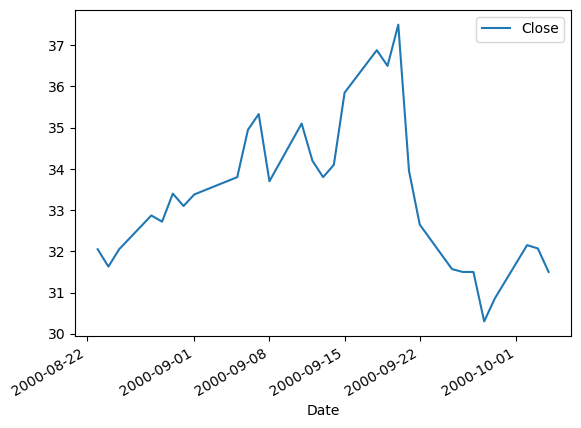

In [8]:
data = yf.download("CL=F", start="1999-03-02", end="2000-10-5")
data.to_csv('WTI Crude Oil')
data= data.dropna()
data = data[['Close']] #filter out other column data
data.plot()
pyplot.show()

To this:

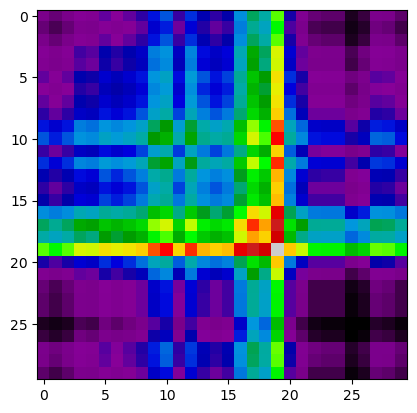

In [12]:
GAFs = GramianAngularField(method = 'summation', sample_range = (0,1))
GAF_train = GAFs.fit_transform(trainX)
plt.imshow(GAF_train[0], cmap = 'nipy_spectral')
plt.show()

If you look at this long enough, it begins to make sense. GAF images encode the temporal information from the top left to the bottom right. In this colormap, red is the high values and the black and purple would be the lowest values. Do you see how the middle of the graph and the middle of the GAF represent the same data?

# Plan

As previously stated, we aim to construct a convolutional neural network which is able to classify a set of historical trading data into long or short positions. In this project, we will use 30 day overlapping subsets of the data. As stated before, every 30 day GAF will be labeled as "long" if the 31st day's closing price (which is not encoded in the GAF) is greater than the 30th day's closing price (which is in the GAF). We will first load in the data from Yahoo Finance, create our overlapping subsets (each subset incrementing by one day's closing price), and construct the GAFs for each series. Then we will classify each image into "long" or "short" labels and save these to a local folder. Once we finally have the data created, we preprocess accordingly and begin to fit our model. Note there is not much preprocessing to be done since no augmentation is allowed (any change to the GAFs would affect the data encoded in the image). We will start with a base benchmarking case- a simple vanilla network with few layers an few neurons and work our way up to the best network we can produce (and that can run with my memory restrictions). Once we get a proper benchmark and the results make sense, we will begin our hyperparameter tuning. The hyperparameter tuning will be guided by both educated predictions and some "hopeful" experimentation. Hopefully we can construct a network that classifies something above 50%. Let's aim for an a classification accuracy of 52%, as in the long run, this would indicate positive gains (as long as we can afford to lose some!).

# Predictions
I predict the first benchmark test might come out a bit strange, because the outcome we are trying to predict is not very complex (does the next days number go up or down), so I imagine the model's largest problem will be overfitting which will be the bulk of the hyperparameter tuning. Since Barra et al (2) came to 56% accuracy in the best case with sophisticated models, large quantities of data, and high computational power, I don't expect our own model to achieve anything better than this. If we can predict over the testing set above 50%, I believe the project will be a success. In our case, our framework does have limitations, mainly the lack of large quantities of data. The WTI Crude Oil data we scrape only gives us about 5500 GAFs, and with no data augmentation, this is certainly a problem. While we may not come away with a strategy to become rich off commodity futures, this project nevertheless will be a productive experience in our study of neural networks as well as being an interesting application to the problem of forecasting financial markets.

Citations:

(1) https://arxiv.org/abs/1506.00327

(2) https://www.iris.unina.it/retrieve/handle/11588/807057/337910/IEEE_CAA_Journal_of_Automatica_Sinica-3.pdf

# Data Creation and Preparation

Data acquisition is simple using the yfinance package. We can directly import the data from Yahoo Finance which will give us the last 22 years worth of trading data, day-by-day of WTI Crude Oil. We'll clean this data up a bit, taking out skipped days and the like. Our data spans from August 22, 2000 to November 19th, 2022 (as far back as we can go on Yahoo Finance). This puts us directly in line with the monumental commodity booms that took place around 2008 and during the Covid pandemic. This is good because it is always good to incorporate all kinds of events into our data to hinder certain data problems like survivorship bias. We'll be preprocessing our data to only be looking at the closing price for WTI Crude futures. The closing price is the value in USD of the last future's price on that day. We will do our work with the price history from WTI Crude, preprocess our data, and run a backtest then tune hyperaparameters. 

A large portion of this project is simply creating the data ourselves. We must take the time series data and convert it to thousands of images in order to use convolutional network strategies for classification. By the end of this section, we'll have created over 5000 GAFs that are labeled "long" or "short".

Let's start by importing the data from Yahoo Finance and cleaning it up a bit.

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib

numGPUs = len(tf.config.experimental.list_physical_devices('GPU'))

print('Num GPUs Available: ', numGPUs)

if numGPUs > 0:
    print(tf.test.gpu_device_name())
    print(device_lib.list_local_devices()[1].physical_device_desc)

Num GPUs Available:  1
/device:GPU:0
device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5


First, we'll import the data and take a look at its form. 

In [3]:
data = yf.download("CL=F", start="1999-03-02", end="2022-10-15")
data.to_csv('WTI Crude Oil')
data= data.dropna()
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-08-23 00:00:00-04:00,31.950001,32.799999,31.950001,32.049999,32.049999,79385
2000-08-24 00:00:00-04:00,31.900000,32.240002,31.400000,31.629999,31.629999,72978
2000-08-25 00:00:00-04:00,31.700001,32.099998,31.320000,32.049999,32.049999,44601
2000-08-28 00:00:00-04:00,32.040001,32.919998,31.860001,32.869999,32.869999,46770
2000-08-29 00:00:00-04:00,32.820000,33.029999,32.560001,32.720001,32.720001,49131
...,...,...,...,...,...,...
2022-10-10 00:00:00-04:00,93.480003,93.639999,90.540001,91.129997,91.129997,289508
2022-10-11 00:00:00-04:00,91.139999,91.349998,87.910004,89.349998,89.349998,333158
2022-10-12 00:00:00-04:00,88.669998,90.070000,86.279999,87.269997,87.269997,332271


Looks like a good dataset to me, let's filter out the columns except for "Close" and construct our numpy array sequences. 

Now we move on to splitting our data into testing and training sets. We'll use an 80/20 split, that is, the first 80% of the trading days will be our training data and the remaining 20% will be our test data. There will be no scaling here because we will scale when we pass the data through the GAF class. 

In [4]:
data = data[['Close']] #filter out other column data
closeVals = data.values #turn our data to numpy array for manipulation
train = math.floor(len(closeVals)* 0.80) # 80% training data length, notice floor is used to round integer (decimal time stamp doesn't make any sense)

In [6]:
len(closeVals)

5562

In [10]:
train

4449

As we expected, we have 5,562 row of trading days and then 80% of that, 4,449 days, makes up our training period. Now we need to construct datasets which use the last months worth of closing prices as subsets throughout our training and testing periods. In this study we would like to use one month's worth of trading data (which would truly be 25 since you do not trade on weekends) so we use 30 days. We'll need to create training and testing lists and append our 30 days data inside them, then convert to arrays. We want our network to carry to analyze each thirty day sequence and decide whether or not the 31st day will have an increase or decrease in closing price.

We convert these to numpy arrays and then reshape (probably not needed for GAF).

Please note this code is essentially the same code from my first project, with a slight modification to ensure training and testing datasets are not overlapping. The problem in the first project was the way I defined the monthTest variable, as it pulled the last twenty-nine days from the training into the testing. We've changed this now as to ensure there is no overlap at the loss of 60 days worth of trading data.

In [12]:

seqdays = 30  #number of days used to construct each subset
monthTrain = closeVals[0:train  , : ]          #take scaled rows from zero to length of train row , colon is all columns data ; takes first timestep to last in training along with all closing prices
monthTest = closeVals[train: , : ]   #, scaled rows from end of training period minus sequence trading days to end of testing period (the last day of trading data) with all closing prices
trainX = [] #create list for append functions; lists can grow dynamically, but we will need a numpy array soon
testX = []
for i in range(seqdays, len(monthTrain)):       #30 to length of rows
    trainX.append(monthTrain[i-seqdays:i, 0])   #creates sequence for 30 days training , take close column with us    
for i in range(seqdays,len(monthTest)):
    testX.append(monthTest[i-seqdays:i,0])
trainX= np.array(trainX)                        # makes lists arrays for numpy
testX = np.array(testX)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1]))  # reshape to 2d array for feed-forward NN; first coord is reshaping x_train, second coord reshapes to proper rows and columns
testX = np.reshape(testX, (testX.shape[0],testX.shape[1]))       

In [11]:
len(closeVals)

5562

In [13]:
len(trainX) + len(testX)

5502

In [14]:
len(trainX)

4419

In [15]:
len(testX)

1083

Why did we lose 60 days worth of trading data? Well, to ensure there is no overlap between our testing set and training set, I changed the monthTest variable to start at train and go to the end of the dataframe. Thus, when we construct the sequences of arrays, we lose the first 30 days after the end of the training data and the last 30 days (because you cannot make the last sequence without 30 days worth of values). To make sure we don't have overlap, we can compare the last values of the training set and the first values of the testing set. When I did this on my old code, I quickly realized there was a mixture between the two to my horror.

In [16]:
trainX

array([[32.04999924, 31.62999916, 32.04999924, ..., 32.15000153,
        32.06999969, 31.5       ],
       [31.62999916, 32.04999924, 32.86999893, ..., 32.06999969,
        31.5       , 30.64999962],
       [32.04999924, 32.86999893, 32.72000122, ..., 31.5       ,
        30.64999962, 30.85000038],
       ...,
       [63.50999832, 63.36999893, 63.54000092, ..., 71.36000061,
        70.69999695, 70.95999908],
       [63.36999893, 63.54000092, 62.06000137, ..., 70.69999695,
        70.95999908, 71.30999756],
       [63.54000092, 62.06000137, 63.41999817, ..., 70.95999908,
        71.30999756, 71.48999786]])

In [17]:
testX

array([[71.27999878, 72.23999786, 72.12999725, ..., 72.76000214,
        73.44999695, 74.15000153],
       [72.23999786, 72.12999725, 71.83999634, ..., 73.44999695,
        74.15000153, 73.94000244],
       [72.12999725, 71.83999634, 70.70999908, ..., 74.15000153,
        73.94000244, 74.13999939],
       ...,
       [91.63999939, 89.55000305, 86.61000061, ..., 92.63999939,
        91.12999725, 89.34999847],
       [89.55000305, 86.61000061, 86.87000275, ..., 91.12999725,
        89.34999847, 87.26999664],
       [86.61000061, 86.87000275, 86.87999725, ..., 89.34999847,
        87.26999664, 89.11000061]])

No overlap between the two. This might not be the most efficient way, but it guarantees we have separate data in the sets. Now, let's construct the Gramian Angular Fields for each sequence.

For more on pyts module and the GAF class, see (3) https://pyts.readthedocs.io/en/stable/generated/pyts.image.GramianAngularField.html

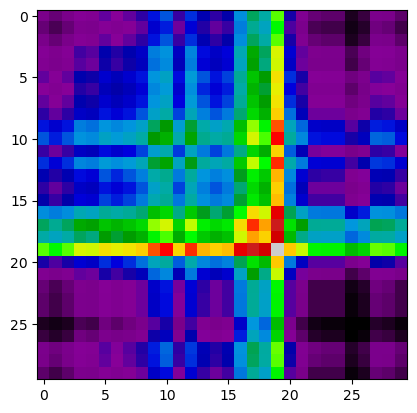

In [21]:
GAFs = GramianAngularField(method = 'summation', sample_range = (0,1))
GAF_train = GAFs.fit_transform(trainX)
GAF_test = GAFs.transform(testX)
# plot one image
plt.imshow(GAF_train[0], cmap = 'nipy_spectral')
plt.show()

Looks pretty cool! This is the GAF for the first 30 days of the time series for WTI Crude in August of 2000. Now, we need to classify each series as either "long" or "short" and save each one into their respective folders for both the training and the testing sets. 

For classification, I have opted to label a "long" position as when the closing price of the last value in any particular series is less than the closing price of the last value in the next series. That is, we are comparing if the closing price one day was less than the closing price the next day.

A "short" position is the opposite, that is if the previous day's closing price was greater than the next day's closing price.

I chose this simple strategy because it the 30th + 1 day's value is not encoded in any sequence. Thus, if a prediction is correct, the model will be accurately predicting whether a certain GAF's data tells us there will be a price increase or decrease. 

For classification labeling and directory saving, these two medium guides helped me a lot: 

https://towardsdatascience.com/how-to-encode-time-series-into-images-for-financial-forecasting-using-convolutional-neural-networks-5683eb5c53d9

https://medium.com/@davidheffernan_99410/using-image-recognition-to-predict-stock-trends-e29f48147250

In [23]:
path = 'C:\\Users\\c334-\\GAFs\\train\\'
dirname = os.path.dirname(path)
def strategy(currentday, nextday):
    if nextday > currentday:
        position = 'long'
    else:
        position = 'short'
    return position
cmap = 'nipy_spectral'
for i in range(0,len(trainX)):
    direction = strategy(trainX[i][-1], trainX[i+1][-1]) #currentday = current series last day , nextday = next series last day
    plt.figure(figsize=(8, 8))
    plt.imshow(GAF_train[i], cmap=cmap, origin='upper')
    plt.axis('off')
    plt.savefig(os.path.join(path,direction,"imgtrain" + str(i)), transparent=True, bbox_inches='tight')
    plt.close()

IndexError: index 4419 is out of bounds for axis 0 with size 4419

In [25]:
path = 'C:\\Users\\c334-\\GAFs\\test\\'
dirname = os.path.dirname(path)
def strategy(currentday, nextday):
    if nextday > currentday:
        position = 'long'
    else:
        position = 'short'
    return position
for i in range(0,len(testX)):
    direction = strategy(testX[i][-1], testX[i+1][-1])
    plt.figure(figsize=(8, 8))
    plt.imshow(GAF_test[i], cmap='nipy_spectral', origin='upper')
    plt.axis('off')
    plt.savefig(os.path.join(path,direction,"imgtest" + str(i)), transparent=True, bbox_inches='tight')
    plt.close()

IndexError: index 1083 is out of bounds for axis 0 with size 1083

There was an error because I tried to pull from out of the index, but all the photos still saved successfully. 

Now, let's load these photos themselves and preprocess them accordingly. First we'll load each, into a training, validation, and testing set. The training/validation split is 80/20. We choose a batch size of 32 and a normalized image size of 180x180.

Help here comes from tensorflow itself: https://www.tensorflow.org/tutorials/load_data/images#create_a_dataset

I use a categorial label here because originally I was having problems with my classification only predicting one class successfully. Once I switched to categorical labels, with a last layer of 2 neurons with softmax activation, it began to predict both classes. For more on this see this stack exchange post which guided me: https://datascience.stackexchange.com/questions/45833/keras-model-only-predicts-one-class-for-all-the-test-images

In [3]:
data_dir = 'C:\\Users\\c334-\\GAFs\\train\\'
data_dirtest = 'C:\\Users\\c334-\\GAFs\\test\\'
batch_size = 32
img_height = 180
img_width = 180

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=334,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4418 files belonging to 2 classes.
Using 3535 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=334,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4418 files belonging to 2 classes.
Using 883 files for validation.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dirtest,
  validation_split=None,
  subset=None,
  seed=None,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1082 files belonging to 2 classes.


In [31]:
class_names = train_ds.class_names
print(class_names)

['long', 'short']


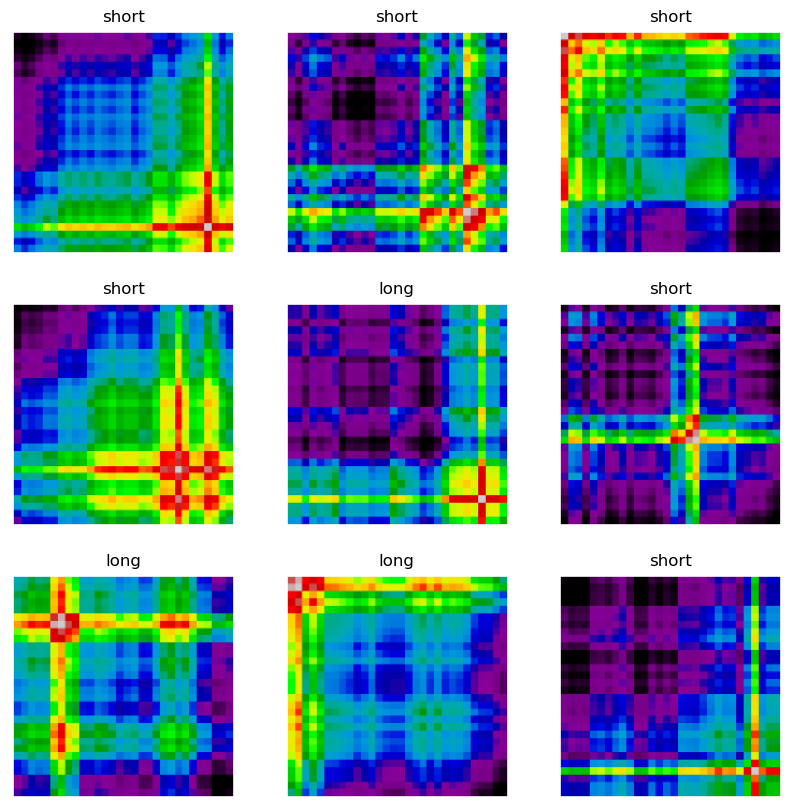

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
    plt.axis("off")

Looks like it is working out so far, it sees both classes and the numbers line up. 

In [35]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>

Visualization sources: 

https://stackoverflow.com/questions/70456447/batchdataset-display-images-and-label

https://www.tensorflow.org/tutorials/load_data/images#create_a_dataset

The last thing to do before we can begin to run our model is to do any remaining preprocessing. The good news (and bad news) is that there is not much preprocessing to be done. There is no chance for data augmentation since any change in the photo will change our data encoding. For example, if we change the brightness on a GAF, the values encoded will be fundamentally different. If we rotate it, the time series would be distorted in some way. Simply put, we cannot augment the GAFs without changing the structure of the time series, so augmentation is out of the question. We already have our data in batches, and we have resized everything before to 180. However, we will use autotune on the data as well as shuffling the training images.

I repeat we will shuffle the training images. This might seem wrong, but I believe it depends on how you want to look at the problem. If we shuffle the training, we are no longer seeing any gradual transformations to the images and the time aspect is lost respective to the next image in the folder. However, if we argue that we are desiring to construct a model that can take any random sequence of time series data and make an accurate prediction, this is perfect. If we shuffle our training data, we are not training the model to any one particular security, rather, the model will learn how to best accurately classify any securities GAF at a random interval. So we shuffle the data. This is all essentially copied code from my homework 3 with some bits commented out.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE  #allocates and optimizes CPU budget during runtime, since we're using GPU, I don't think this helps- but it doesn't hurt.

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
batch_size = 32 #define function which will resize,rescale and augment any dataset we need depending on parameters (we don't augment or shuffle val or test)
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
 # ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              #num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
 # ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [9]:
train_ds = prepare(train_ds, shuffle=True, augment=False) #augment and shuffle our training dataset only
val_ds = prepare(val_ds,shuffle=False, augment=False)
test_ds = prepare(test_ds,shuffle=False, augment=False)

Now that this is all taken care of, let's move on to the benchmark test.

# Benchmark Test

For the benchmark test, we'll keep it simple with a few convolutional layers with relu activation and one dense layer. We'll use adam optimizer.

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  #tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation  = 'softmax')
])

In [4]:
#optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

Epoch 1/10
111/111 [==============================] - 12s 54ms/step - loss: 335.7643 - accuracy: 0.4866 - val_loss: 0.6932 - val_accuracy: 0.4915
Epoch 2/10
111/111 [==============================] - 5s 45ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5085
Epoch 3/10
111/111 [==============================] - 5s 45ms/step - loss: 0.6930 - accuracy: 0.5174 - val_loss: 0.6930 - val_accuracy: 0.5085
Epoch 4/10
111/111 [==============================] - 5s 46ms/step - loss: 0.6929 - accuracy: 0.5174 - val_loss: 0.6930 - val_accuracy: 0.5085
Epoch 5/10
111/111 [==============================] - 5s 46ms/step - loss: 0.6928 - accuracy: 0.5174 - val_loss: 0.6930 - val_accuracy: 0.5085
Epoch 6/10
111/111 [==============================] - 5s 46ms/step - loss: 0.6927 - accuracy: 0.5174 - val_loss: 0.6930 - val_accuracy: 0.5085
Epoch 7/10
111/111 [==============================] - 5s 46ms/step - loss: 0.6926 - accuracy: 0.5174 - val_loss: 0.6930 - val_accuracy: 0.5

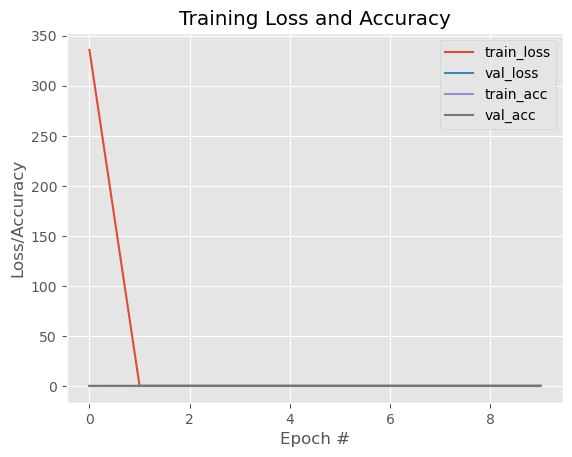

In [5]:
epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Contrary to my first prediction, we couldn't really learn at all. So, this isn't the best "benchmark", but we can work with it to try to solve some problems. Now let's go into the true hyperparameter tuning/model construction portion of the project.

# Hyperparameter Tuning

Let's increase the power of the system, we'll increase the architecture with more layers and more neurons and add Max Pooling.

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  #tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(500, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation  = 'softmax')
])


model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
111/111 [==============================] - 10s 38ms/step - loss: 9.9726 - accuracy: 0.5013 - val_loss: 0.6917 - val_accuracy: 0.5164
Epoch 2/10
111/111 [==============================] - 3s 30ms/step - loss: 0.6888 - accuracy: 0.5338 - val_loss: 0.6941 - val_accuracy: 0.5017
Epoch 3/10
111/111 [==============================] - 3s 30ms/step - loss: 0.6749 - accuracy: 0.5610 - val_loss: 0.7036 - val_accuracy: 0.5017
Epoch 4/10
111/111 [==============================] - 3s 30ms/step - loss: 0.6616 - accuracy: 0.5808 - val_loss: 0.7075 - val_accuracy: 0.5108
Epoch 5/10
111/111 [==============================] - 3s 30ms/step - loss: 0.6413 - accuracy: 0.6000 - val_loss: 0.7545 - val_accuracy: 0.5153
Epoch 6/10
111/111 [==============================] - 3s 30ms/step - loss: 0.6099 - accuracy: 0.6416 - val_loss: 0.7673 - val_accuracy: 0.5243
Epoch 7/10
111/111 [==============================] - 3s 30ms/step - loss: 0.5800 - accuracy: 0.6617 - val_loss: 0.8180 - val_accuracy: 0.527

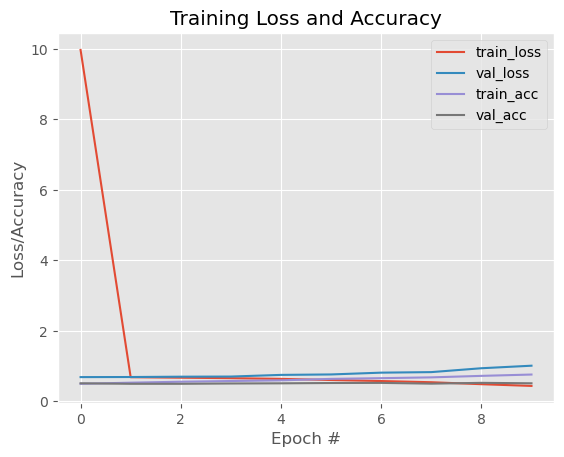

In [4]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Yes, this is much better. We can absolutely see that the model is learning now and the accuracy seems a bit more predictable, we can better consider this to be the benchmark.

One thing to note is that we can easily see overfitting between the training and validation, as the difference in the accuracy between the two grows wider and wider. One main objective when tuning these hyperparameters will be to try to resolve the overfitting as best as we can. 

Next, let's add some dropout regularization and see if we can overfit a bit less. 

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(2, activation = 'softmax')
  
])


model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
111/111 [==============================] - 12s 50ms/step - loss: 28.0248 - accuracy: 0.5185 - val_loss: 0.6932 - val_accuracy: 0.4790
Epoch 2/10
111/111 [==============================] - 5s 41ms/step - loss: 0.6970 - accuracy: 0.5134 - val_loss: 0.6932 - val_accuracy: 0.5085
Epoch 3/10
111/111 [==============================] - 5s 41ms/step - loss: 0.6983 - accuracy: 0.5064 - val_loss: 0.6932 - val_accuracy: 0.5085
Epoch 4/10
111/111 [==============================] - 5s 41ms/step - loss: 0.6973 - accuracy: 0.5024 - val_loss: 0.6932 - val_accuracy: 0.5108
Epoch 5/10
111/111 [==============================] - 5s 41ms/step - loss: 0.6954 - accuracy: 0.5160 - val_loss: 0.6931 - val_accuracy: 0.5108
Epoch 6/10
111/111 [==============================] - 5s 41ms/step - loss: 0.6952 - accuracy: 0.5126 - val_loss: 0.6930 - val_accuracy: 0.5085
Epoch 7/10
111/111 [==============================] - 5s 41ms/step - loss: 0.6937 - accuracy: 0.5134 - val_loss: 0.6930 - val_accuracy: 0.50

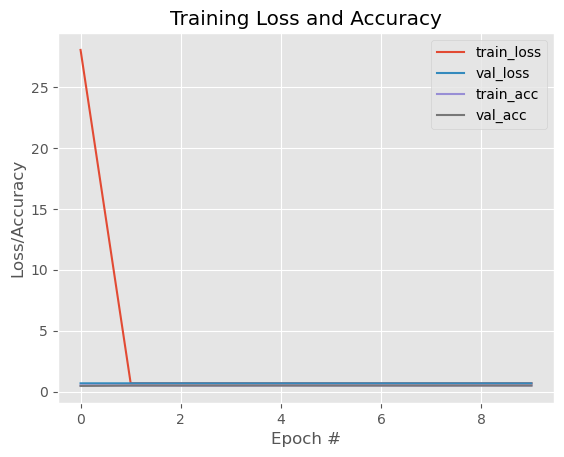

In [4]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Now we're running into the same problem as before. Let's add batch normalization to the same model. I will also increase some neurons to see if we can get that same "overkill" effect.

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(500, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(2, activation = 'softmax')
  
])


model.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
111/111 [==============================] - 13s 62ms/step - loss: 0.9062 - accuracy: 0.4967 - val_loss: 0.8388 - val_accuracy: 0.5153
Epoch 2/10
111/111 [==============================] - 5s 49ms/step - loss: 0.7038 - accuracy: 0.5409 - val_loss: 0.7248 - val_accuracy: 0.4881
Epoch 3/10
111/111 [==============================] - 5s 49ms/step - loss: 0.6668 - accuracy: 0.6048 - val_loss: 0.7352 - val_accuracy: 0.4983
Epoch 4/10
111/111 [==============================] - 5s 49ms/step - loss: 0.6472 - accuracy: 0.6274 - val_loss: 0.8275 - val_accuracy: 0.4983
Epoch 5/10
111/111 [==============================] - 5s 49ms/step - loss: 0.5875 - accuracy: 0.6936 - val_loss: 0.8773 - val_accuracy: 0.5085
Epoch 6/10
111/111 [==============================] - 5s 49ms/step - loss: 0.5498 - accuracy: 0.7256 - val_loss: 0.8902 - val_accuracy: 0.5051
Epoch 7/10
111/111 [==============================] - 5s 49ms/step - loss: 0.4816 - accuracy: 0.7663 - val_loss: 0.8911 - val_accuracy: 0.515

And now we have switched back to the previous problem, we seem to be threading a thin line between overfitting and stagnation. Since the training is becoming way too accurate, let's experiment with different optimizers and learning rates. As Adam is great for converging fast, let's switch to SGD to see if we can generalize better over the validation. We'll try out different learning rates before we return. First learning rate will be 0.001.

Also, we definitely need dropout in our fully connected layer, so we'll add this as well as a flattening layer.

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(500, activation='relu'),
  layers.BatchNormalization(),
  layers.Flatten(),    
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.001)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
111/111 [==============================] - 12s 58ms/step - loss: 1.0643 - accuracy: 0.5007 - val_loss: 0.7386 - val_accuracy: 0.4938
Epoch 2/10
111/111 [==============================] - 5s 45ms/step - loss: 1.0109 - accuracy: 0.5214 - val_loss: 0.7930 - val_accuracy: 0.5040
Epoch 3/10
111/111 [==============================] - 5s 45ms/step - loss: 0.9982 - accuracy: 0.5313 - val_loss: 0.8558 - val_accuracy: 0.5017
Epoch 4/10
111/111 [==============================] - 5s 45ms/step - loss: 0.9636 - accuracy: 0.5338 - val_loss: 0.7569 - val_accuracy: 0.4983
Epoch 5/10
111/111 [==============================] - 5s 45ms/step - loss: 0.9358 - accuracy: 0.5465 - val_loss: 0.7588 - val_accuracy: 0.4892
Epoch 6/10
111/111 [==============================] - 5s 45ms/step - loss: 0.9295 - accuracy: 0.5567 - val_loss: 0.7574 - val_accuracy: 0.4949
Epoch 7/10
111/111 [==============================] - 5s 45ms/step - loss: 0.8880 - accuracy: 0.5737 - val_loss: 0.7878 - val_accuracy: 0.491

Things might be a bit more under control now with regards to overfitting, we've at least cut the difference down pretty well. Let's try a higher learning rate at 0.01.

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(500, activation='relu'),
  layers.BatchNormalization(),
  layers.Flatten(),    
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
111/111 [==============================] - 13s 59ms/step - loss: 1.0317 - accuracy: 0.5027 - val_loss: 0.7700 - val_accuracy: 0.4813
Epoch 2/10
111/111 [==============================] - 5s 47ms/step - loss: 0.8685 - accuracy: 0.5426 - val_loss: 0.7614 - val_accuracy: 0.4972
Epoch 3/10
111/111 [==============================] - 5s 46ms/step - loss: 0.7777 - accuracy: 0.5777 - val_loss: 0.7519 - val_accuracy: 0.4677
Epoch 4/10
111/111 [==============================] - 5s 46ms/step - loss: 0.7169 - accuracy: 0.6093 - val_loss: 0.7463 - val_accuracy: 0.4768
Epoch 5/10
111/111 [==============================] - 5s 47ms/step - loss: 0.6805 - accuracy: 0.6385 - val_loss: 0.7426 - val_accuracy: 0.4915
Epoch 6/10
111/111 [==============================] - 5s 46ms/step - loss: 0.6436 - accuracy: 0.6588 - val_loss: 0.7453 - val_accuracy: 0.4824
Epoch 7/10
111/111 [==============================] - 5s 46ms/step - loss: 0.6208 - accuracy: 0.6713 - val_loss: 0.7756 - val_accuracy: 0.488

0.001 seems to be the better choice for now. We can see the training is learning but the validation is not. One thing that we should try is decreasing the batch size. Let's run the same model with a new batch size of 16 instead of 32, as this might help generalize better, quote "It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize." (4)

(4) https://arxiv.org/abs/1609.04836

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(500, activation='relu'),
  layers.BatchNormalization(),
  layers.Flatten(),    
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.001)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
221/221 [==============================] - 14s 33ms/step - loss: 1.0682 - accuracy: 0.5010 - val_loss: 0.7505 - val_accuracy: 0.5153
Epoch 2/10
221/221 [==============================] - 6s 29ms/step - loss: 0.9982 - accuracy: 0.5250 - val_loss: 0.7423 - val_accuracy: 0.5028
Epoch 3/10
221/221 [==============================] - 6s 28ms/step - loss: 0.9380 - accuracy: 0.5499 - val_loss: 0.7596 - val_accuracy: 0.5176
Epoch 4/10
221/221 [==============================] - 6s 29ms/step - loss: 0.9045 - accuracy: 0.5610 - val_loss: 0.7430 - val_accuracy: 0.4960
Epoch 5/10
221/221 [==============================] - 6s 28ms/step - loss: 0.8772 - accuracy: 0.5771 - val_loss: 0.7406 - val_accuracy: 0.5062
Epoch 6/10
221/221 [==============================] - 6s 28ms/step - loss: 0.8386 - accuracy: 0.5844 - val_loss: 0.7548 - val_accuracy: 0.5017
Epoch 7/10
221/221 [==============================] - 6s 29ms/step - loss: 0.8078 - accuracy: 0.6042 - val_loss: 0.7570 - val_accuracy: 0.506

This seems to make a good difference as expected. Let's try the same thing for a learning rate of 0.01 and see if we're missing anything.

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(500, activation='relu'),
  layers.BatchNormalization(),
  layers.Flatten(),    
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
221/221 [==============================] - 14s 34ms/step - loss: 1.0003 - accuracy: 0.5001 - val_loss: 0.7525 - val_accuracy: 0.4994
Epoch 2/10
221/221 [==============================] - 6s 29ms/step - loss: 0.7918 - accuracy: 0.5471 - val_loss: 0.7414 - val_accuracy: 0.5017
Epoch 3/10
221/221 [==============================] - 6s 29ms/step - loss: 0.7324 - accuracy: 0.5584 - val_loss: 0.7177 - val_accuracy: 0.5176
Epoch 4/10
221/221 [==============================] - 6s 29ms/step - loss: 0.7058 - accuracy: 0.5618 - val_loss: 0.7810 - val_accuracy: 0.4768
Epoch 5/10
221/221 [==============================] - 6s 29ms/step - loss: 0.6787 - accuracy: 0.5912 - val_loss: 0.7403 - val_accuracy: 0.4926
Epoch 6/10
221/221 [==============================] - 6s 28ms/step - loss: 0.6604 - accuracy: 0.6136 - val_loss: 0.8419 - val_accuracy: 0.5096
Epoch 7/10
221/221 [==============================] - 6s 29ms/step - loss: 0.6307 - accuracy: 0.6464 - val_loss: 0.7617 - val_accuracy: 0.481

The results are pretty similar, but LR = 0.001 seems a bit better. We'll revisit other learning rates soon. To cap off our optimizer tuning we'll run a final test with adam at the same rate.

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(500, activation='relu'),
  layers.BatchNormalization(),
  layers.Flatten(),    
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
221/221 [==============================] - 15s 37ms/step - loss: 0.9794 - accuracy: 0.4959 - val_loss: 0.7788 - val_accuracy: 0.4779
Epoch 2/10
221/221 [==============================] - 7s 32ms/step - loss: 0.7977 - accuracy: 0.5395 - val_loss: 0.7218 - val_accuracy: 0.4960
Epoch 3/10
221/221 [==============================] - 7s 31ms/step - loss: 0.7413 - accuracy: 0.5692 - val_loss: 0.7362 - val_accuracy: 0.5006
Epoch 4/10
221/221 [==============================] - 7s 32ms/step - loss: 0.7205 - accuracy: 0.5706 - val_loss: 0.7121 - val_accuracy: 0.5006
Epoch 5/10
221/221 [==============================] - 7s 32ms/step - loss: 0.6807 - accuracy: 0.6071 - val_loss: 0.7416 - val_accuracy: 0.4994
Epoch 6/10
221/221 [==============================] - 7s 32ms/step - loss: 0.6419 - accuracy: 0.6472 - val_loss: 0.7731 - val_accuracy: 0.4904
Epoch 7/10
221/221 [==============================] - 7s 32ms/step - loss: 0.6071 - accuracy: 0.6699 - val_loss: 0.7874 - val_accuracy: 0.494

Next, let's see how weight initialization can help us. Since this is a relu network, we'll opt for Kaiming He initialization. I couldn't find much information on when it is better to employ Normal vs Uniform in the literature, so we will opt for Normal, and test out Uniform near the end of our final model to see if there is any better performance.

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(500, activation='relu'),
  layers.BatchNormalization(),
  layers.Flatten(),    
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.001)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
221/221 [==============================] - 13s 34ms/step - loss: 1.0401 - accuracy: 0.4999 - val_loss: 0.7354 - val_accuracy: 0.5232
Epoch 2/10
221/221 [==============================] - 6s 29ms/step - loss: 0.9889 - accuracy: 0.5216 - val_loss: 0.7369 - val_accuracy: 0.5085
Epoch 3/10
221/221 [==============================] - 6s 29ms/step - loss: 0.9432 - accuracy: 0.5330 - val_loss: 0.7291 - val_accuracy: 0.5176
Epoch 4/10
221/221 [==============================] - 6s 29ms/step - loss: 0.9162 - accuracy: 0.5528 - val_loss: 0.7653 - val_accuracy: 0.5006
Epoch 5/10
221/221 [==============================] - 6s 29ms/step - loss: 0.9183 - accuracy: 0.5395 - val_loss: 0.7377 - val_accuracy: 0.5017
Epoch 6/10
221/221 [==============================] - 6s 29ms/step - loss: 0.8632 - accuracy: 0.5641 - val_loss: 0.7217 - val_accuracy: 0.5096
Epoch 7/10
221/221 [==============================] - 6s 29ms/step - loss: 0.8468 - accuracy: 0.5771 - val_loss: 0.7152 - val_accuracy: 0.498

Per (4), let's change our dropout value to a more reasonable (0.2). I was not aware that not adding dropout to convolutional layers was the norm (is it?), so let's see how our performance does.

(5): http://mipal.snu.ac.kr/images/1/16/Dropout_ACCV2016.pdf

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(500, activation='relu'),
  layers.BatchNormalization(),
  layers.Flatten(),    
  layers.Dropout(0.2),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.001)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
221/221 [==============================] - 14s 35ms/step - loss: 0.9375 - accuracy: 0.4911 - val_loss: 0.8119 - val_accuracy: 0.5119
Epoch 2/10
221/221 [==============================] - 7s 30ms/step - loss: 0.8112 - accuracy: 0.5740 - val_loss: 0.7727 - val_accuracy: 0.5006
Epoch 3/10
221/221 [==============================] - 7s 29ms/step - loss: 0.7223 - accuracy: 0.6342 - val_loss: 0.7781 - val_accuracy: 0.5142
Epoch 4/10
221/221 [==============================] - 7s 30ms/step - loss: 0.6760 - accuracy: 0.6668 - val_loss: 0.7910 - val_accuracy: 0.5266
Epoch 5/10
221/221 [==============================] - 7s 30ms/step - loss: 0.6184 - accuracy: 0.7129 - val_loss: 0.8589 - val_accuracy: 0.5153
Epoch 6/10
221/221 [==============================] - 7s 30ms/step - loss: 0.5839 - accuracy: 0.7386 - val_loss: 0.8019 - val_accuracy: 0.4972
Epoch 7/10
221/221 [==============================] - 7s 29ms/step - loss: 0.5533 - accuracy: 0.7562 - val_loss: 0.8216 - val_accuracy: 0.507

We've reverted to much worse overfitting, so now let's add some new regularization techniques, that is L1 or L2. We choose L1 at 0.01. We'll give a test for L2 later in our experimentation round.

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(500, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),
  layers.Flatten(),    
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.001)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
221/221 [==============================] - 16s 42ms/step - loss: 1188.7302 - accuracy: 0.5064 - val_loss: 909.0622 - val_accuracy: 0.4915
Epoch 2/10
221/221 [==============================] - 8s 36ms/step - loss: 693.3004 - accuracy: 0.5420 - val_loss: 504.2720 - val_accuracy: 0.5130
Epoch 3/10
221/221 [==============================] - 8s 35ms/step - loss: 368.4106 - accuracy: 0.5850 - val_loss: 254.8186 - val_accuracy: 0.5119
Epoch 4/10
221/221 [==============================] - 8s 35ms/step - loss: 180.3859 - accuracy: 0.5856 - val_loss: 121.1683 - val_accuracy: 0.4983
Epoch 5/10
221/221 [==============================] - 8s 35ms/step - loss: 89.5877 - accuracy: 0.5463 - val_loss: 65.9189 - val_accuracy: 0.4779
Epoch 6/10
221/221 [==============================] - 8s 35ms/step - loss: 57.4137 - accuracy: 0.5129 - val_loss: 51.5936 - val_accuracy: 0.4870
Epoch 7/10
221/221 [==============================] - 8s 35ms/step - loss: 50.0378 - accuracy: 0.4996 - val_loss: 48.707

We can kind of see a weird trend here where even though loss is decreasing, the accuracy in both can be worse. This makes me think we have overdone regularization, so we'll take out the dropout. Now that we're averaging decent results over 50% without atrocious overfitting, let's start to predict over the test set and see how we do.

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(500, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),
  layers.Flatten(),    
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.001)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
221/221 [==============================] - 15s 39ms/step - loss: 1188.8394 - accuracy: 0.5021 - val_loss: 909.1425 - val_accuracy: 0.4915
Epoch 2/10
221/221 [==============================] - 7s 34ms/step - loss: 692.9150 - accuracy: 0.6631 - val_loss: 504.1696 - val_accuracy: 0.5062
Epoch 3/10
221/221 [==============================] - 7s 33ms/step - loss: 367.9679 - accuracy: 0.7140 - val_loss: 254.3589 - val_accuracy: 0.5153
Epoch 4/10
221/221 [==============================] - 7s 33ms/step - loss: 180.0536 - accuracy: 0.6733 - val_loss: 122.6654 - val_accuracy: 0.5108
Epoch 5/10
221/221 [==============================] - 7s 33ms/step - loss: 90.0891 - accuracy: 0.5915 - val_loss: 66.8293 - val_accuracy: 0.4994
Epoch 6/10
221/221 [==============================] - 7s 34ms/step - loss: 58.4381 - accuracy: 0.5214 - val_loss: 53.8474 - val_accuracy: 0.4677
Epoch 7/10
221/221 [==============================] - 7s 33ms/step - loss: 51.7120 - accuracy: 0.5007 - val_loss: 49.690


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.54      0.69      0.61       594
           1       0.43      0.29      0.34       488

    accuracy                           0.51      1082
   macro avg       0.49      0.49      0.48      1082
weighted avg       0.49      0.51      0.49      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

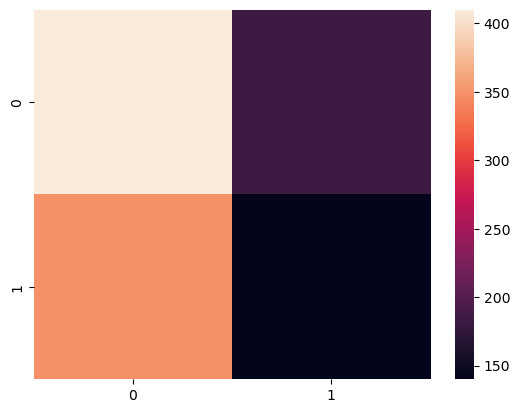

<Figure size 640x480 with 0 Axes>

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

51%! That's not too bad. Let's add a bit of complexity to the model and double each layer.

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.001)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
221/221 [==============================] - 48s 180ms/step - loss: 1901.0458 - accuracy: 0.4970 - val_loss: 977.2797 - val_accuracy: 0.5108
Epoch 2/10
221/221 [==============================] - 35s 160ms/step - loss: 504.7437 - accuracy: 0.6622 - val_loss: 196.8152 - val_accuracy: 0.5164
Epoch 3/10
221/221 [==============================] - 35s 160ms/step - loss: 109.7223 - accuracy: 0.5607 - val_loss: 78.2098 - val_accuracy: 0.5198
Epoch 4/10
221/221 [==============================] - 35s 160ms/step - loss: 73.1612 - accuracy: 0.5149 - val_loss: 70.1319 - val_accuracy: 0.5017
Epoch 5/10
221/221 [==============================] - 36s 162ms/step - loss: 67.7440 - accuracy: 0.4905 - val_loss: 63.5308 - val_accuracy: 0.5130
Epoch 6/10
221/221 [==============================] - 35s 160ms/step - loss: 61.3140 - accuracy: 0.4990 - val_loss: 57.5107 - val_accuracy: 0.5198
Epoch 7/10
221/221 [==============================] - 36s 162ms/step - loss: 55.1506 - accuracy: 0.4894 - val_lo


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.56      0.42      0.48       594
           1       0.46      0.59      0.52       488

    accuracy                           0.50      1082
   macro avg       0.51      0.51      0.50      1082
weighted avg       0.51      0.50      0.50      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

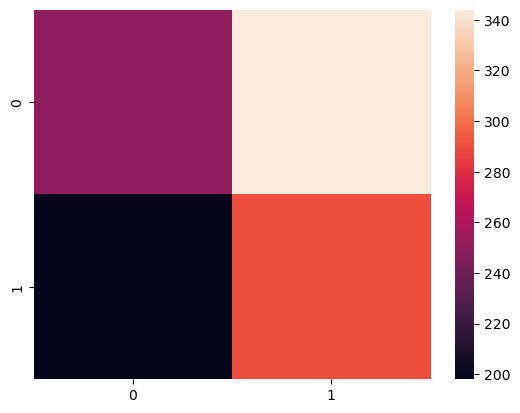

<Figure size 640x480 with 0 Axes>

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

With Adam:

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
221/221 [==============================] - 52s 197ms/step - loss: 313.6592 - accuracy: 0.5149 - val_loss: 205.2665 - val_accuracy: 0.4824
Epoch 2/10
221/221 [==============================] - 39s 177ms/step - loss: 201.6319 - accuracy: 0.5134 - val_loss: 202.7096 - val_accuracy: 0.4858
Epoch 3/10
221/221 [==============================] - 39s 177ms/step - loss: 181.3221 - accuracy: 0.5024 - val_loss: 179.5881 - val_accuracy: 0.4779
Epoch 4/10
221/221 [==============================] - 39s 178ms/step - loss: 172.7514 - accuracy: 0.5225 - val_loss: 165.8492 - val_accuracy: 0.5085
Epoch 5/10
221/221 [==============================] - 39s 177ms/step - loss: 171.1306 - accuracy: 0.4976 - val_loss: 171.0046 - val_accuracy: 0.4734
Epoch 6/10
221/221 [==============================] - 39s 177ms/step - loss: 171.1458 - accuracy: 0.5157 - val_loss: 169.2221 - val_accuracy: 0.5096
Epoch 7/10
221/221 [==============================] - 39s 177ms/step - loss: 170.4462 - accuracy: 0.5132 -

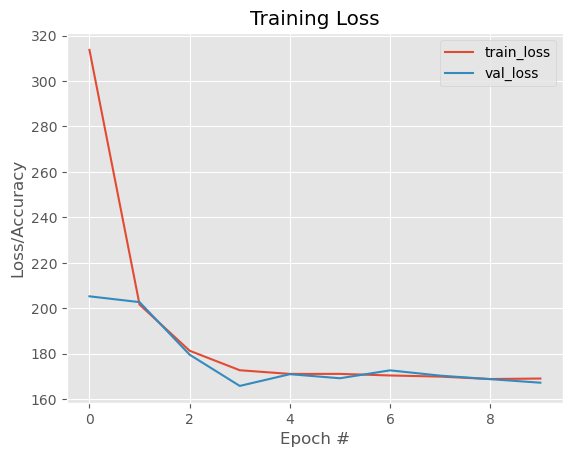

In [9]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


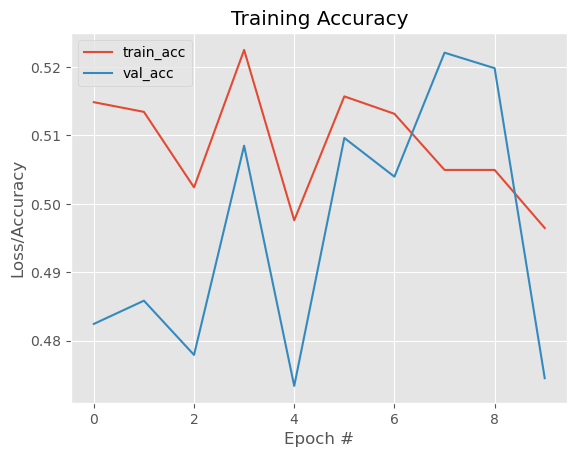

In [10]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()



Testing Classification Report:

               precision    recall  f1-score   support

           0       0.54      0.75      0.63       594
           1       0.43      0.23      0.30       488

    accuracy                           0.51      1082
   macro avg       0.49      0.49      0.46      1082
weighted avg       0.49      0.51      0.48      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

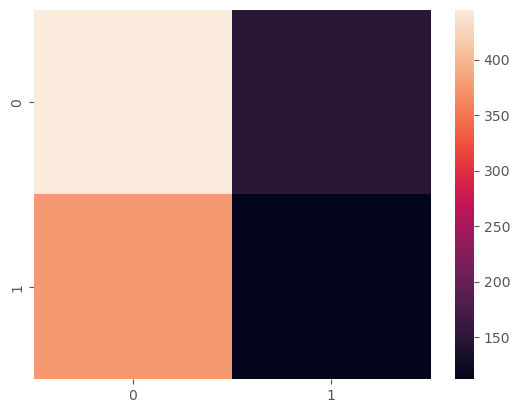

<Figure size 640x480 with 0 Axes>

In [8]:
# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Since we had decent success with a higher learning rate, let's implement that in our updated model:

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
221/221 [==============================] - 48s 181ms/step - loss: 386.3739 - accuracy: 0.4996 - val_loss: 133.5051 - val_accuracy: 0.5108
Epoch 2/10
221/221 [==============================] - 36s 162ms/step - loss: 124.0164 - accuracy: 0.4973 - val_loss: 111.4271 - val_accuracy: 0.5028
Epoch 3/10
221/221 [==============================] - 36s 162ms/step - loss: 105.0195 - accuracy: 0.5069 - val_loss: 96.5943 - val_accuracy: 0.5130
Epoch 4/10
221/221 [==============================] - 36s 162ms/step - loss: 91.3842 - accuracy: 0.4965 - val_loss: 86.7070 - val_accuracy: 0.5085
Epoch 5/10
221/221 [==============================] - 36s 161ms/step - loss: 84.3287 - accuracy: 0.4854 - val_loss: 82.0076 - val_accuracy: 0.5108
Epoch 6/10
221/221 [==============================] - 35s 161ms/step - loss: 80.7874 - accuracy: 0.4982 - val_loss: 78.3339 - val_accuracy: 0.4802
Epoch 7/10
221/221 [==============================] - 35s 161ms/step - loss: 78.6180 - accuracy: 0.4942 - val_los

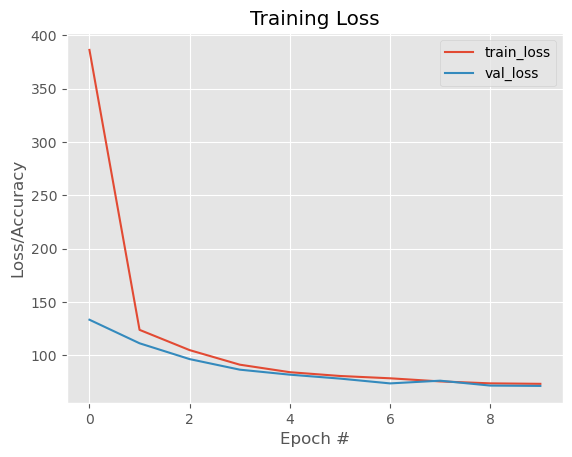

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


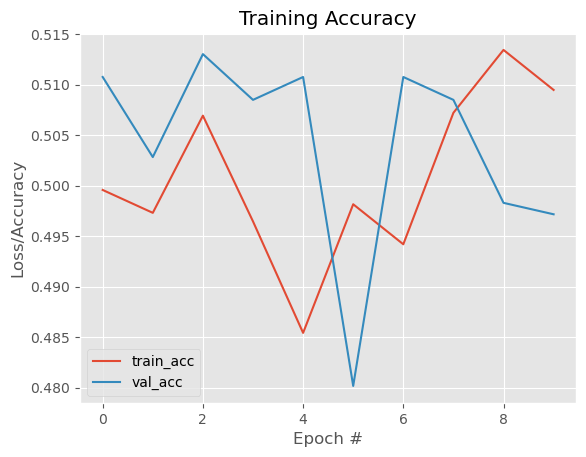

In [5]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()



Testing Classification Report:

               precision    recall  f1-score   support

           0       0.58      0.73      0.65       594
           1       0.52      0.36      0.42       488

    accuracy                           0.56      1082
   macro avg       0.55      0.54      0.54      1082
weighted avg       0.55      0.56      0.55      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

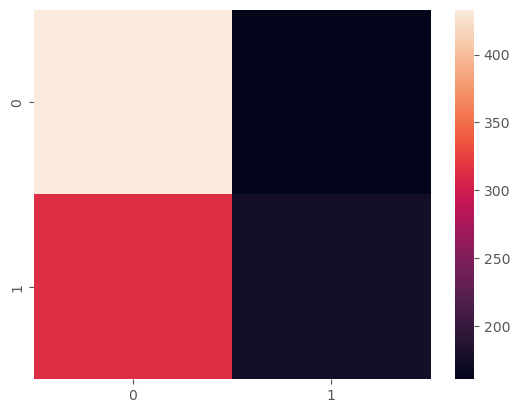

<Figure size 640x480 with 0 Axes>

In [6]:
# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

I will not argue with 56%. This is by far the best return we've had yet, and likely the model that we will keep. Below shows some experimental tests on this model to see if we could improve by tweaking the hyperparameters already present.

I think the high 56% value might be a bit of a fluke, so I want see if we can standardize that a little before we call it.

Returning the dropout:

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
221/221 [==============================] - 51s 190ms/step - loss: 392.6616 - accuracy: 0.5055 - val_loss: 139.4270 - val_accuracy: 0.5096
Epoch 2/10
221/221 [==============================] - 37s 169ms/step - loss: 126.9921 - accuracy: 0.5030 - val_loss: 111.4715 - val_accuracy: 0.4757
Epoch 3/10
221/221 [==============================] - 37s 169ms/step - loss: 105.1257 - accuracy: 0.5055 - val_loss: 98.8696 - val_accuracy: 0.5391
Epoch 4/10
221/221 [==============================] - 37s 168ms/step - loss: 96.0440 - accuracy: 0.4956 - val_loss: 92.1156 - val_accuracy: 0.5085
Epoch 5/10
221/221 [==============================] - 37s 169ms/step - loss: 86.7168 - accuracy: 0.4945 - val_loss: 84.3108 - val_accuracy: 0.5085
Epoch 6/10
221/221 [==============================] - 37s 169ms/step - loss: 82.1823 - accuracy: 0.4990 - val_loss: 78.0225 - val_accuracy: 0.5425
Epoch 7/10
221/221 [==============================] - 37s 169ms/step - loss: 78.0168 - accuracy: 0.5047 - val_los

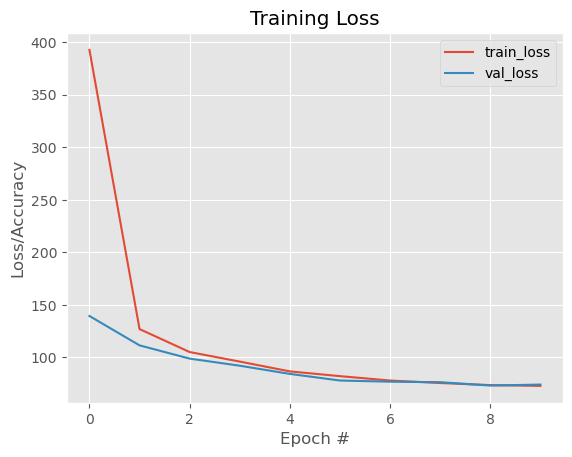

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


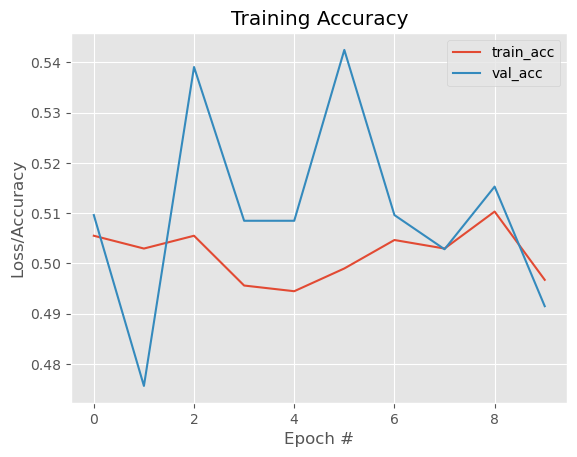

In [5]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()



Testing Classification Report:

               precision    recall  f1-score   support

           0       0.53      0.19      0.27       594
           1       0.45      0.80      0.57       488

    accuracy                           0.46      1082
   macro avg       0.49      0.49      0.42      1082
weighted avg       0.49      0.46      0.41      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

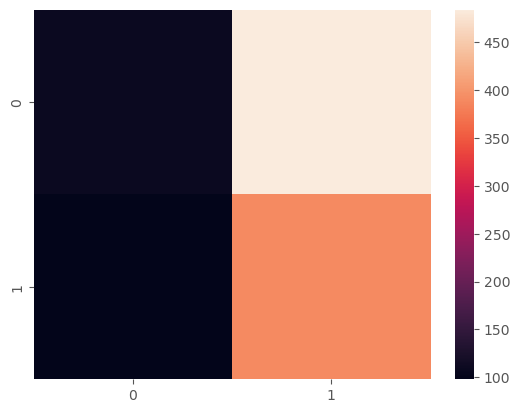

<Figure size 640x480 with 0 Axes>

In [6]:
# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Yes, certainly will keep dropout away. Next, lowering the L1 value:

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.001), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.001), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.001), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.001)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
221/221 [==============================] - 48s 180ms/step - loss: 193.6350 - accuracy: 0.5174 - val_loss: 101.5516 - val_accuracy: 0.5142
Epoch 2/10
221/221 [==============================] - 36s 163ms/step - loss: 54.1699 - accuracy: 0.5661 - val_loss: 23.2277 - val_accuracy: 0.5062
Epoch 3/10
221/221 [==============================] - 35s 161ms/step - loss: 13.3173 - accuracy: 0.5505 - val_loss: 15.5081 - val_accuracy: 0.4915
Epoch 4/10
221/221 [==============================] - 36s 162ms/step - loss: 10.1346 - accuracy: 0.5007 - val_loss: 9.6185 - val_accuracy: 0.4870
Epoch 5/10
221/221 [==============================] - 36s 161ms/step - loss: 7.8421 - accuracy: 0.4931 - val_loss: 7.4257 - val_accuracy: 0.4960
Epoch 6/10
221/221 [==============================] - 36s 162ms/step - loss: 7.2053 - accuracy: 0.4956 - val_loss: 6.5060 - val_accuracy: 0.5153
Epoch 7/10
221/221 [==============================] - 36s 163ms/step - loss: 6.7497 - accuracy: 0.5222 - val_loss: 6.8445


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.50      0.00      0.00       594
           1       0.45      1.00      0.62       488

    accuracy                           0.45      1082
   macro avg       0.48      0.50      0.31      1082
weighted avg       0.48      0.45      0.28      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

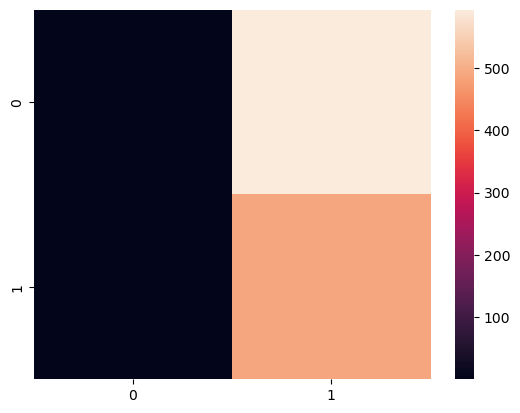

<Figure size 640x480 with 0 Axes>

In [5]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Now we'll test L2:

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
221/221 [==============================] - 49s 181ms/step - loss: 15.2145 - accuracy: 0.5182 - val_loss: 14.5008 - val_accuracy: 0.4790
Epoch 2/10
221/221 [==============================] - 36s 161ms/step - loss: 13.8074 - accuracy: 0.6430 - val_loss: 13.3494 - val_accuracy: 0.4858
Epoch 3/10
221/221 [==============================] - 36s 161ms/step - loss: 12.6061 - accuracy: 0.7431 - val_loss: 12.4716 - val_accuracy: 0.5119
Epoch 4/10
221/221 [==============================] - 36s 162ms/step - loss: 11.4912 - accuracy: 0.8339 - val_loss: 11.5611 - val_accuracy: 0.5164
Epoch 5/10
221/221 [==============================] - 36s 161ms/step - loss: 10.4670 - accuracy: 0.9018 - val_loss: 10.9423 - val_accuracy: 0.5289
Epoch 6/10
221/221 [==============================] - 36s 161ms/step - loss: 9.5768 - accuracy: 0.9468 - val_loss: 10.3705 - val_accuracy: 0.5040
Epoch 7/10
221/221 [==============================] - 36s 162ms/step - loss: 8.7826 - accuracy: 0.9669 - val_loss: 9.64


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.53      0.51      0.52       594
           1       0.43      0.45      0.44       488

    accuracy                           0.48      1082
   macro avg       0.48      0.48      0.48      1082
weighted avg       0.48      0.48      0.48      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

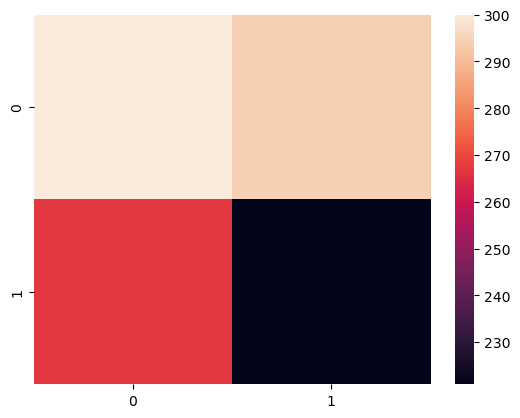

<Figure size 640x480 with 0 Axes>

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

L2 gave us crazy overfitting. Transitioning to He Uniform:

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
221/221 [==============================] - 50s 183ms/step - loss: 393.4623 - accuracy: 0.4990 - val_loss: 140.4895 - val_accuracy: 0.5085
Epoch 2/10
221/221 [==============================] - 36s 162ms/step - loss: 121.8650 - accuracy: 0.4999 - val_loss: 119.2681 - val_accuracy: 0.4915
Epoch 3/10
221/221 [==============================] - 36s 163ms/step - loss: 103.4800 - accuracy: 0.5103 - val_loss: 91.8348 - val_accuracy: 0.5040
Epoch 4/10
221/221 [==============================] - 36s 163ms/step - loss: 89.7374 - accuracy: 0.4891 - val_loss: 84.1017 - val_accuracy: 0.5085
Epoch 5/10
221/221 [==============================] - 36s 162ms/step - loss: 82.9258 - accuracy: 0.5044 - val_loss: 85.7718 - val_accuracy: 0.5130
Epoch 6/10
221/221 [==============================] - 36s 162ms/step - loss: 79.5702 - accuracy: 0.4928 - val_loss: 80.4507 - val_accuracy: 0.5074
Epoch 7/10
221/221 [==============================] - 36s 162ms/step - loss: 75.5666 - accuracy: 0.4970 - val_los


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.57      0.52      0.54       594
           1       0.47      0.51      0.49       488

    accuracy                           0.52      1082
   macro avg       0.52      0.52      0.52      1082
weighted avg       0.52      0.52      0.52      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

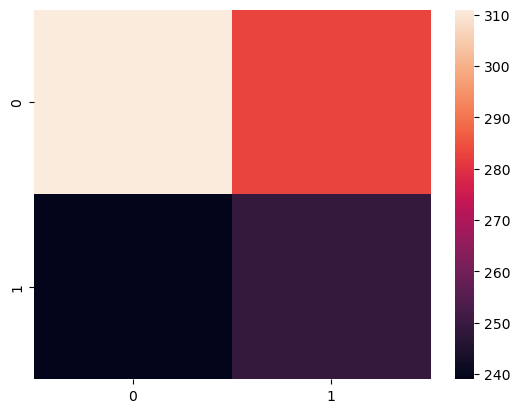

<Figure size 640x480 with 0 Axes>

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

He Uniform worked pretty well, maybe we can compare it at the end to our final model. Dropping all initialization:

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3, kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
221/221 [==============================] - 49s 183ms/step - loss: 377.4713 - accuracy: 0.5075 - val_loss: 125.6811 - val_accuracy: 0.4915
Epoch 2/10
221/221 [==============================] - 36s 161ms/step - loss: 105.2072 - accuracy: 0.4885 - val_loss: 89.2773 - val_accuracy: 0.5096
Epoch 3/10
221/221 [==============================] - 36s 162ms/step - loss: 82.4429 - accuracy: 0.5016 - val_loss: 78.0541 - val_accuracy: 0.5085
Epoch 4/10
221/221 [==============================] - 36s 162ms/step - loss: 75.4930 - accuracy: 0.4905 - val_loss: 74.2655 - val_accuracy: 0.4723
Epoch 5/10
221/221 [==============================] - 36s 162ms/step - loss: 72.4948 - accuracy: 0.5038 - val_loss: 73.2225 - val_accuracy: 0.5130
Epoch 6/10
221/221 [==============================] - 36s 162ms/step - loss: 72.8087 - accuracy: 0.5066 - val_loss: 73.1040 - val_accuracy: 0.5142
Epoch 7/10
221/221 [==============================] - 36s 161ms/step - loss: 72.4650 - accuracy: 0.4922 - val_loss:


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.56      0.85      0.67       594
           1       0.49      0.18      0.27       488

    accuracy                           0.55      1082
   macro avg       0.52      0.51      0.47      1082
weighted avg       0.53      0.55      0.49      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

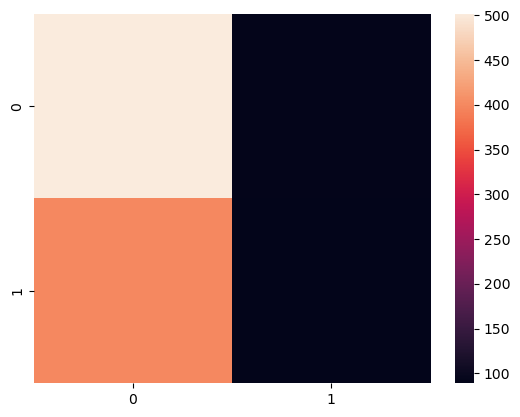

<Figure size 640x480 with 0 Axes>

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Something to keep in mind, this is pretty good. Adding a third layer to the architecture:

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),  
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
221/221 [==============================] - 29s 97ms/step - loss: 302.3237 - accuracy: 0.5038 - val_loss: 60.1271 - val_accuracy: 0.4915
Epoch 2/10
221/221 [==============================] - 19s 86ms/step - loss: 48.2266 - accuracy: 0.4854 - val_loss: 39.0580 - val_accuracy: 0.5277
Epoch 3/10
221/221 [==============================] - 19s 86ms/step - loss: 34.0511 - accuracy: 0.4987 - val_loss: 29.2332 - val_accuracy: 0.4757
Epoch 4/10
221/221 [==============================] - 19s 86ms/step - loss: 27.1446 - accuracy: 0.5171 - val_loss: 24.9382 - val_accuracy: 0.4768
Epoch 5/10
221/221 [==============================] - 19s 87ms/step - loss: 23.0667 - accuracy: 0.5132 - val_loss: 20.9413 - val_accuracy: 0.4700
Epoch 6/10
221/221 [==============================] - 19s 86ms/step - loss: 20.6772 - accuracy: 0.5120 - val_loss: 20.8512 - val_accuracy: 0.5119
Epoch 7/10
221/221 [==============================] - 19s 86ms/step - loss: 19.7549 - accuracy: 0.5163 - val_loss: 19.3791 


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.56      0.82      0.67       594
           1       0.50      0.23      0.31       488

    accuracy                           0.55      1082
   macro avg       0.53      0.52      0.49      1082
weighted avg       0.54      0.55      0.51      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

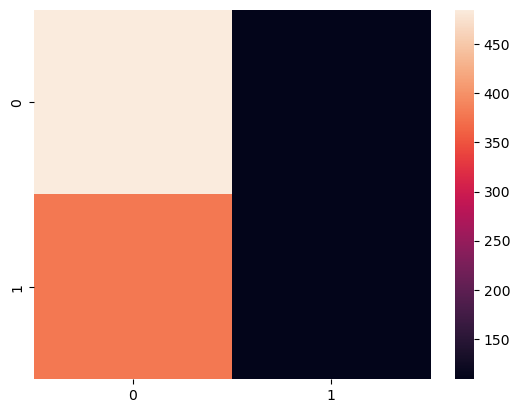

<Figure size 640x480 with 0 Axes>

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

This is also pretty good. Less neurons:

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(16, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
221/221 [==============================] - 17s 47ms/step - loss: 288.9396 - accuracy: 0.4990 - val_loss: 50.2588 - val_accuracy: 0.4983
Epoch 2/10
221/221 [==============================] - 9s 40ms/step - loss: 42.9558 - accuracy: 0.5109 - val_loss: 36.6457 - val_accuracy: 0.5017
Epoch 3/10
221/221 [==============================] - 9s 40ms/step - loss: 32.5455 - accuracy: 0.5103 - val_loss: 29.6749 - val_accuracy: 0.5017
Epoch 4/10
221/221 [==============================] - 9s 40ms/step - loss: 27.4962 - accuracy: 0.5058 - val_loss: 26.2064 - val_accuracy: 0.4847
Epoch 5/10
221/221 [==============================] - 9s 40ms/step - loss: 24.4991 - accuracy: 0.5081 - val_loss: 23.0165 - val_accuracy: 0.5130
Epoch 6/10
221/221 [==============================] - 9s 41ms/step - loss: 22.0685 - accuracy: 0.5083 - val_loss: 20.4971 - val_accuracy: 0.5142
Epoch 7/10
221/221 [==============================] - 9s 40ms/step - loss: 20.7636 - accuracy: 0.5103 - val_loss: 19.3057 - val_


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.54      0.68      0.60       594
           1       0.44      0.30      0.35       488

    accuracy                           0.51      1082
   macro avg       0.49      0.49      0.48      1082
weighted avg       0.49      0.51      0.49      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

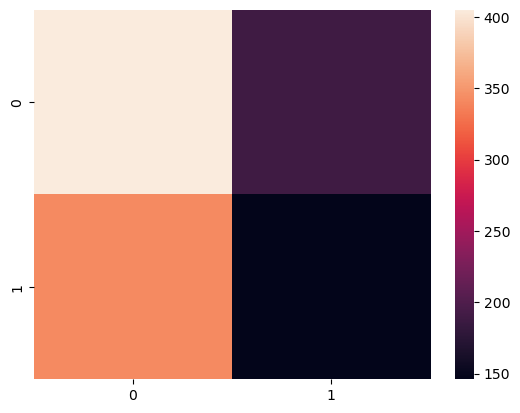

<Figure size 640x480 with 0 Axes>

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Higher learning rate of 0.15:

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.015)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
221/221 [==============================] - 21s 63ms/step - loss: 232.1191 - accuracy: 0.4962 - val_loss: 58.6230 - val_accuracy: 0.5119
Epoch 2/10
221/221 [==============================] - 12s 55ms/step - loss: 48.1275 - accuracy: 0.5174 - val_loss: 39.6826 - val_accuracy: 0.5085
Epoch 3/10
221/221 [==============================] - 12s 55ms/step - loss: 35.6142 - accuracy: 0.5050 - val_loss: 31.6359 - val_accuracy: 0.4915
Epoch 4/10
221/221 [==============================] - 12s 55ms/step - loss: 31.2088 - accuracy: 0.5030 - val_loss: 29.6005 - val_accuracy: 0.5096
Epoch 5/10
221/221 [==============================] - 12s 55ms/step - loss: 29.6535 - accuracy: 0.5115 - val_loss: 29.2844 - val_accuracy: 0.5051
Epoch 6/10
221/221 [==============================] - 12s 55ms/step - loss: 29.0622 - accuracy: 0.4970 - val_loss: 29.6110 - val_accuracy: 0.5277
Epoch 7/10
221/221 [==============================] - 12s 55ms/step - loss: 29.2565 - accuracy: 0.5089 - val_loss: 29.1100 


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.50      0.37      0.42       594
           1       0.42      0.56      0.48       488

    accuracy                           0.45      1082
   macro avg       0.46      0.46      0.45      1082
weighted avg       0.47      0.45      0.45      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

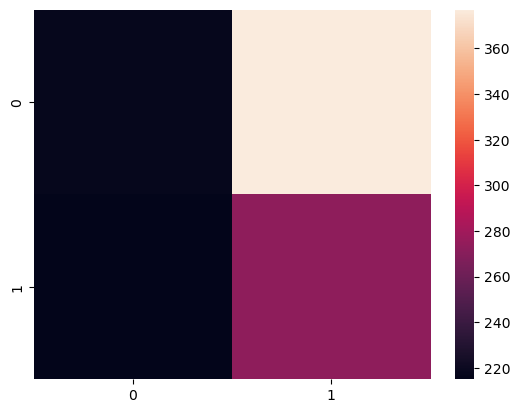

<Figure size 640x480 with 0 Axes>

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Lower learning rate of 0.005:

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.005)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
221/221 [==============================] - 24s 76ms/step - loss: 523.6404 - accuracy: 0.5016 - val_loss: 74.5042 - val_accuracy: 0.5017
Epoch 2/10
221/221 [==============================] - 14s 65ms/step - loss: 58.9499 - accuracy: 0.5199 - val_loss: 48.6765 - val_accuracy: 0.4915
Epoch 3/10
221/221 [==============================] - 14s 65ms/step - loss: 43.4543 - accuracy: 0.5021 - val_loss: 37.2789 - val_accuracy: 0.4949
Epoch 4/10
221/221 [==============================] - 15s 67ms/step - loss: 33.2596 - accuracy: 0.5086 - val_loss: 29.8322 - val_accuracy: 0.4892
Epoch 5/10
221/221 [==============================] - 15s 67ms/step - loss: 26.8816 - accuracy: 0.5219 - val_loss: 24.5395 - val_accuracy: 0.5006
Epoch 6/10
221/221 [==============================] - 14s 65ms/step - loss: 22.1679 - accuracy: 0.5086 - val_loss: 20.1077 - val_accuracy: 0.5006
Epoch 7/10
221/221 [==============================] - 14s 65ms/step - loss: 18.5585 - accuracy: 0.4982 - val_loss: 17.4114 


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.55      0.69      0.61       594
           1       0.45      0.31      0.37       488

    accuracy                           0.52      1082
   macro avg       0.50      0.50      0.49      1082
weighted avg       0.50      0.52      0.50      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

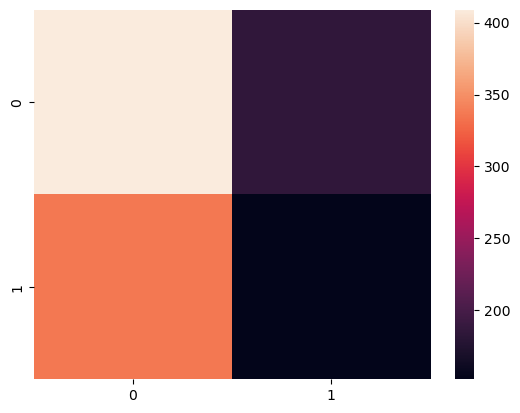

<Figure size 640x480 with 0 Axes>

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Adding the third layer was the only experiment which gave us a second class precision of 50 or higher, so let's combine that with our other promising find, He Uniform initialization, and see if we can do any better.

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),  
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
221/221 [==============================] - 28s 97ms/step - loss: 306.2017 - accuracy: 0.4925 - val_loss: 63.1360 - val_accuracy: 0.5130
Epoch 2/10
221/221 [==============================] - 19s 88ms/step - loss: 50.8994 - accuracy: 0.5007 - val_loss: 39.5045 - val_accuracy: 0.5062
Epoch 3/10
221/221 [==============================] - 19s 88ms/step - loss: 34.2574 - accuracy: 0.5004 - val_loss: 28.8658 - val_accuracy: 0.5142
Epoch 4/10
221/221 [==============================] - 19s 87ms/step - loss: 25.6121 - accuracy: 0.5041 - val_loss: 23.9545 - val_accuracy: 0.5074
Epoch 5/10
221/221 [==============================] - 19s 87ms/step - loss: 21.4963 - accuracy: 0.4970 - val_loss: 21.6407 - val_accuracy: 0.5130
Epoch 6/10
221/221 [==============================] - 19s 86ms/step - loss: 20.3810 - accuracy: 0.4950 - val_loss: 19.8869 - val_accuracy: 0.4870
Epoch 7/10
221/221 [==============================] - 19s 86ms/step - loss: 19.6450 - accuracy: 0.4894 - val_loss: 21.1821 


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.56      0.29      0.39       594
           1       0.46      0.72      0.56       488

    accuracy                           0.49      1082
   macro avg       0.51      0.51      0.47      1082
weighted avg       0.51      0.49      0.46      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

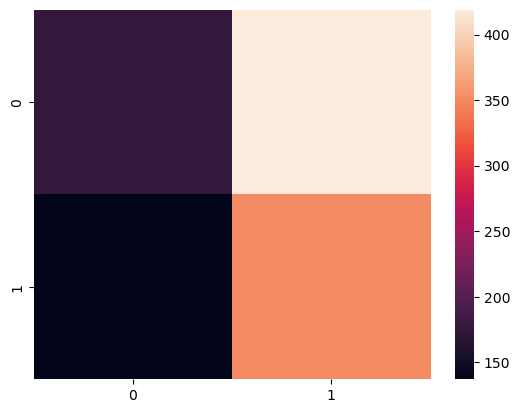

<Figure size 640x480 with 0 Axes>

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Nothing too great. In another lifetime.

Let's do three runs on both the three layer and two layer runs to see which has better generalized performance. Each time we will tune the epochs. First, the two layer model:

#  Two Layer Model Runs

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
221/221 [==============================] - 49s 183ms/step - loss: 383.8084 - accuracy: 0.5106 - val_loss: 136.6063 - val_accuracy: 0.5085
Epoch 2/10
221/221 [==============================] - 36s 163ms/step - loss: 125.9411 - accuracy: 0.5004 - val_loss: 112.6652 - val_accuracy: 0.4881
Epoch 3/10
221/221 [==============================] - 36s 164ms/step - loss: 109.8281 - accuracy: 0.5035 - val_loss: 96.6015 - val_accuracy: 0.5277
Epoch 4/10
221/221 [==============================] - 36s 163ms/step - loss: 97.0788 - accuracy: 0.5058 - val_loss: 93.9956 - val_accuracy: 0.5379
Epoch 5/10
221/221 [==============================] - 36s 163ms/step - loss: 87.6394 - accuracy: 0.5030 - val_loss: 82.6494 - val_accuracy: 0.5085
Epoch 6/10
221/221 [==============================] - 36s 162ms/step - loss: 82.0323 - accuracy: 0.4996 - val_loss: 76.4408 - val_accuracy: 0.5142
Epoch 7/10
221/221 [==============================] - 36s 162ms/step - loss: 78.7926 - accuracy: 0.5035 - val_los


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.55      0.96      0.70       594
           1       0.49      0.04      0.08       488

    accuracy                           0.55      1082
   macro avg       0.52      0.50      0.39      1082
weighted avg       0.52      0.55      0.42      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

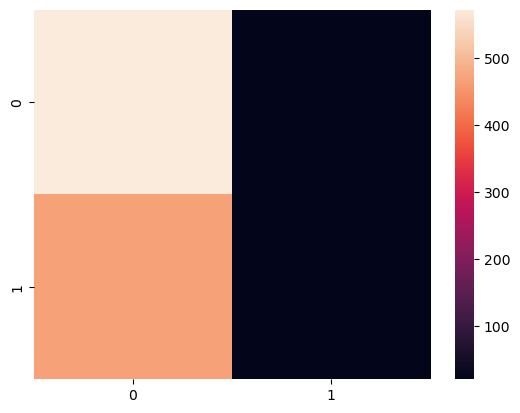

<Figure size 640x480 with 0 Axes>

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=7

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/7
221/221 [==============================] - 49s 181ms/step - loss: 402.0703 - accuracy: 0.4987 - val_loss: 132.8650 - val_accuracy: 0.5074
Epoch 2/7
221/221 [==============================] - 36s 161ms/step - loss: 116.6981 - accuracy: 0.4863 - val_loss: 108.2523 - val_accuracy: 0.4983
Epoch 3/7
221/221 [==============================] - 36s 161ms/step - loss: 98.5540 - accuracy: 0.5112 - val_loss: 91.5588 - val_accuracy: 0.4915
Epoch 4/7
221/221 [==============================] - 36s 161ms/step - loss: 87.8875 - accuracy: 0.4928 - val_loss: 85.4016 - val_accuracy: 0.5085
Epoch 5/7
221/221 [==============================] - 36s 161ms/step - loss: 81.1605 - accuracy: 0.4993 - val_loss: 77.8615 - val_accuracy: 0.5085
Epoch 6/7
221/221 [==============================] - 36s 162ms/step - loss: 77.9546 - accuracy: 0.5001 - val_loss: 79.4818 - val_accuracy: 0.5187
Epoch 7/7
221/221 [==============================] - 36s 162ms/step - loss: 76.0560 - accuracy: 0.5004 - val_loss: 74.33


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.55      0.69      0.61       594
           1       0.46      0.33      0.39       488

    accuracy                           0.52      1082
   macro avg       0.51      0.51      0.50      1082
weighted avg       0.51      0.52      0.51      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

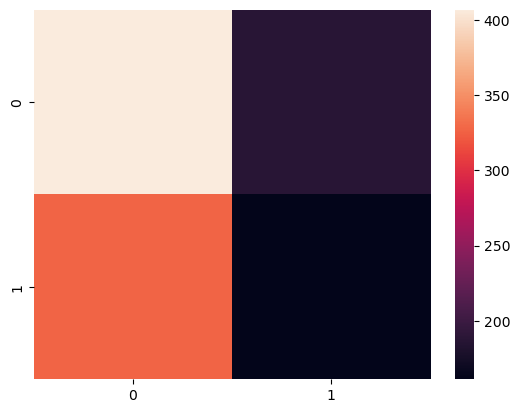

<Figure size 640x480 with 0 Axes>

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=7

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/7
221/221 [==============================] - 48s 180ms/step - loss: 378.5218 - accuracy: 0.5038 - val_loss: 133.6499 - val_accuracy: 0.5040
Epoch 2/7
221/221 [==============================] - 35s 160ms/step - loss: 117.6047 - accuracy: 0.5120 - val_loss: 108.1425 - val_accuracy: 0.4926
Epoch 3/7
221/221 [==============================] - 35s 160ms/step - loss: 100.0505 - accuracy: 0.4996 - val_loss: 92.8983 - val_accuracy: 0.5164
Epoch 4/7
221/221 [==============================] - 35s 160ms/step - loss: 90.9982 - accuracy: 0.5120 - val_loss: 88.7535 - val_accuracy: 0.5187
Epoch 5/7
221/221 [==============================] - 35s 160ms/step - loss: 84.9923 - accuracy: 0.5151 - val_loss: 83.8635 - val_accuracy: 0.4915
Epoch 6/7
221/221 [==============================] - 35s 160ms/step - loss: 79.8741 - accuracy: 0.5041 - val_loss: 85.4844 - val_accuracy: 0.4960
Epoch 7/7
221/221 [==============================] - 35s 160ms/step - loss: 76.8460 - accuracy: 0.5064 - val_loss: 75.7


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.54      0.89      0.67       594
           1       0.35      0.07      0.12       488

    accuracy                           0.52      1082
   macro avg       0.44      0.48      0.39      1082
weighted avg       0.45      0.52      0.42      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

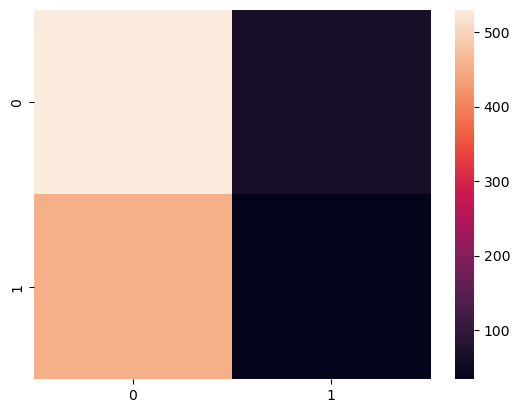

<Figure size 640x480 with 0 Axes>

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

# Three Three Layer Runs:

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),  
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=10

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
221/221 [==============================] - 30s 100ms/step - loss: 302.0874 - accuracy: 0.4908 - val_loss: 61.1953 - val_accuracy: 0.4790
Epoch 2/10
221/221 [==============================] - 20s 89ms/step - loss: 51.0519 - accuracy: 0.5143 - val_loss: 42.9659 - val_accuracy: 0.5130
Epoch 3/10
221/221 [==============================] - 19s 88ms/step - loss: 36.5501 - accuracy: 0.5086 - val_loss: 33.0606 - val_accuracy: 0.4881
Epoch 4/10
221/221 [==============================] - 19s 87ms/step - loss: 29.0832 - accuracy: 0.5064 - val_loss: 26.7852 - val_accuracy: 0.5470
Epoch 5/10
221/221 [==============================] - 19s 87ms/step - loss: 24.3762 - accuracy: 0.5066 - val_loss: 21.5363 - val_accuracy: 0.5085
Epoch 6/10
221/221 [==============================] - 19s 86ms/step - loss: 21.4462 - accuracy: 0.5004 - val_loss: 20.6526 - val_accuracy: 0.4711
Epoch 7/10
221/221 [==============================] - 19s 86ms/step - loss: 20.0248 - accuracy: 0.5115 - val_loss: 20.0442


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.57      0.21      0.30       594
           1       0.46      0.81      0.59       488

    accuracy                           0.48      1082
   macro avg       0.51      0.51      0.44      1082
weighted avg       0.52      0.48      0.43      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

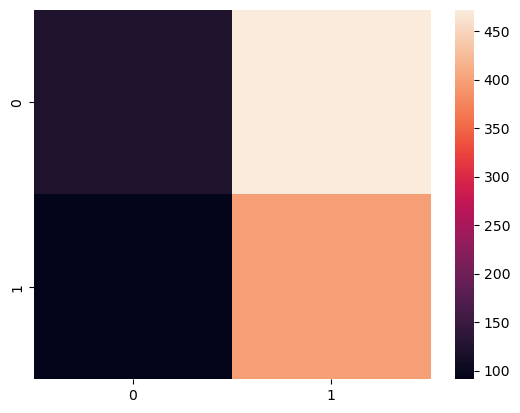

<Figure size 640x480 with 0 Axes>

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),  
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=7

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/7
221/221 [==============================] - 29s 99ms/step - loss: 303.6565 - accuracy: 0.4911 - val_loss: 58.7917 - val_accuracy: 0.4994
Epoch 2/7
221/221 [==============================] - 20s 89ms/step - loss: 48.0601 - accuracy: 0.4982 - val_loss: 39.2934 - val_accuracy: 0.5187
Epoch 3/7
221/221 [==============================] - 20s 88ms/step - loss: 34.1236 - accuracy: 0.5123 - val_loss: 29.8899 - val_accuracy: 0.4881
Epoch 4/7
221/221 [==============================] - 20s 89ms/step - loss: 26.8189 - accuracy: 0.4917 - val_loss: 23.9122 - val_accuracy: 0.5108
Epoch 5/7
221/221 [==============================] - 20s 89ms/step - loss: 22.9148 - accuracy: 0.5027 - val_loss: 21.8149 - val_accuracy: 0.5085
Epoch 6/7
221/221 [==============================] - 20s 89ms/step - loss: 20.8856 - accuracy: 0.4982 - val_loss: 21.3962 - val_accuracy: 0.4983
Epoch 7/7
221/221 [==============================] - 20s 89ms/step - loss: 19.9123 - accuracy: 0.5055 - val_loss: 19.7640 - val_a


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.54      0.50      0.52       594
           1       0.44      0.47      0.45       488

    accuracy                           0.49      1082
   macro avg       0.49      0.49      0.49      1082
weighted avg       0.49      0.49      0.49      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

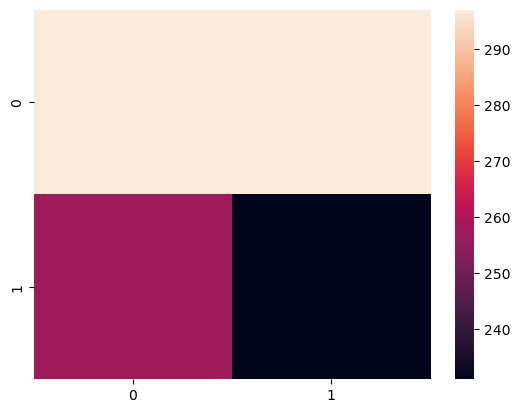

<Figure size 640x480 with 0 Axes>

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

In [3]:
num_classes = 2

model = tf.keras.Sequential([
  layers.Conv2D(32, 3,kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),  
  #layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Conv2D(128, 3,  padding='same',kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01), activation='relu'),
  layers.BatchNormalization(),
  layers.Conv2D(128, 3,  padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  #layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
  layers.BatchNormalization(),   
  layers.Dropout(0.5),
  layers.Dense(2, activation = 'softmax')
  
])

optimizer = keras.optimizers.SGD(learning_rate=0.01)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
  metrics=['accuracy'])

epochs=7

H = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/7
221/221 [==============================] - 29s 99ms/step - loss: 305.5317 - accuracy: 0.4911 - val_loss: 66.5523 - val_accuracy: 0.5096
Epoch 2/7
221/221 [==============================] - 19s 87ms/step - loss: 49.6155 - accuracy: 0.5047 - val_loss: 39.8375 - val_accuracy: 0.4915
Epoch 3/7
221/221 [==============================] - 19s 87ms/step - loss: 34.4392 - accuracy: 0.4965 - val_loss: 30.0113 - val_accuracy: 0.5085
Epoch 4/7
221/221 [==============================] - 19s 88ms/step - loss: 27.0174 - accuracy: 0.4956 - val_loss: 24.5693 - val_accuracy: 0.5187
Epoch 5/7
221/221 [==============================] - 19s 88ms/step - loss: 23.3690 - accuracy: 0.5248 - val_loss: 21.7975 - val_accuracy: 0.4915
Epoch 6/7
221/221 [==============================] - 19s 88ms/step - loss: 20.8988 - accuracy: 0.5033 - val_loss: 20.5517 - val_accuracy: 0.5255
Epoch 7/7
221/221 [==============================] - 19s 88ms/step - loss: 19.9380 - accuracy: 0.5072 - val_loss: 19.9974 - val_a


Testing Classification Report:

               precision    recall  f1-score   support

           0       0.50      0.16      0.25       594
           1       0.44      0.80      0.57       488

    accuracy                           0.45      1082
   macro avg       0.47      0.48      0.41      1082
weighted avg       0.47      0.45      0.39      1082


Testing Confusion Matrix:



<Figure size 640x480 with 0 Axes>

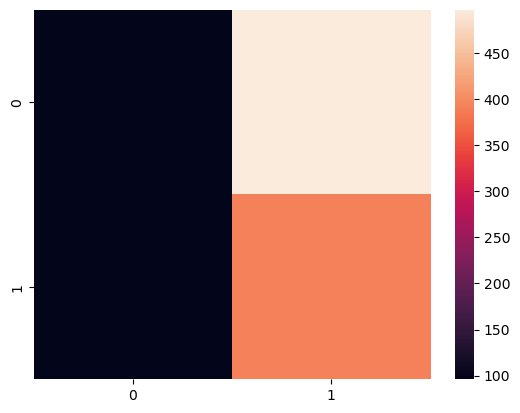

<Figure size 640x480 with 0 Axes>

In [4]:
from seaborn import heatmap
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# predict the labels of the test set
predictedY = model.predict(test_ds)
predictedY = tf.argmax(predictedY, axis=1)
testY = tf.concat([y for x, y in test_ds], axis=0) 

# print quality metricsl
print('\nTesting Classification Report:\n\n', classification_report(testY, predictedY))



print('\nTesting Confusion Matrix:\n')

heatmap(confusion_matrix(testY, predictedY))
plt.figure()

Clearly, the two layer model gives us better results and with that we move have our final model.

# Final Model 

In [9]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 batch_normalization_14 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 batch_normalization_15 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 64)      18496     
                                                                 
 batch_normalization_16 (Bat  (None, 180, 180, 64)    

Our final model consists of six two-dimensional convolutional layers, each with batch normalization and max pooling, and two final dense layers, the first with batch normalization. The neurons for the network grow from 32 to 64 to 128 respectively across the convolutional layers, and 512 neurons and 2 respectively for the feed-forward portion. We employ the ReLu activation function in every layer, as well Kaiming He weight initialization and L1 regularization with a value of 0.01. The final dense layer uses the softmax activation function and has two neurons for classification. Dropout regularization appears after the first dense layer.

This model was found to have optimal performance around seven epochs, and uses a loss optimizer of Stochastic Gradient Descent with learning rate 0.01. Our batch size is 16.

# Conclusion 

To conclude, we have taken thirty day subsets of WTI Crude Oil future prices from twenty-two years worth of trading data and converted each subset into Gramian Angular Field images. These GAF images were then classified as either "long" or "short" depending on whether the price of Crude Oil increased in the day after the end of the sequence. With these images classified, we preprocess accordingly and construct an optimal model which attempts to classify each GAF image correctly  into the long or short labels. In the end, the model was classifying each GAF correctly between 52 to 56 percent of the time. While this might seem like poor accuracy, in financial markets achieving greater than 50% accuracy on correct trades can make any investor a profitable sum. Our own accuracy closely reflects the other accuracy in the literature we have researched, albeit perhaps not as reliably. 

In the future, many things could be done to improve upon this project. The most glaring problem would be the small amount of data, as we only had around 5,500 GAF images to work with. Acquiring data with many more samples would improve the accuracy and reliability of the model tremendously for one. Alternatively, perhaps a novel method of data augmentation could be developed (or found in the literature) which would allow us to manipulate a GAF in order to artificially enrich our training set. Second, better models could be constructed using more advanced methods. This project did not use any transfer learning, but it could potentially pay off to use other pre-built models. More research should be done on the models which were said to achieve over 60% accuracy using Gramian Angular Fields. 

Additionally, I would find it interesting to use this application to make long-term investment decisions rather than just short-term (i.e. the next day). If a method could be constructed which could accurately classify positions weeks or even months ahead with decent reliability, the possibilies are endless.

Of course, this model is not recommended to be used to make real-world financial decisions. Financial data is extremely complex and the historical closing price of a security is simply not enough to be able to forecast wisely. Nevertheless, the use of converting time series data is a novel and exciting concept which enriches the deep learning world. The relative recency of these Gramian Angular Fields is promising and provides practitioners of finance and deep learning alike an innovative way to tackle a timeless problem, that is, predicting the future.